In [2]:
#conda activate orchids-env

!conda list | grep matplotlib
!pip freeze | grep pandas

matplotlib                3.7.2                    pypi_0    pypi
matplotlib-inline         0.1.6                    pypi_0    pypi
pandas==2.0.3


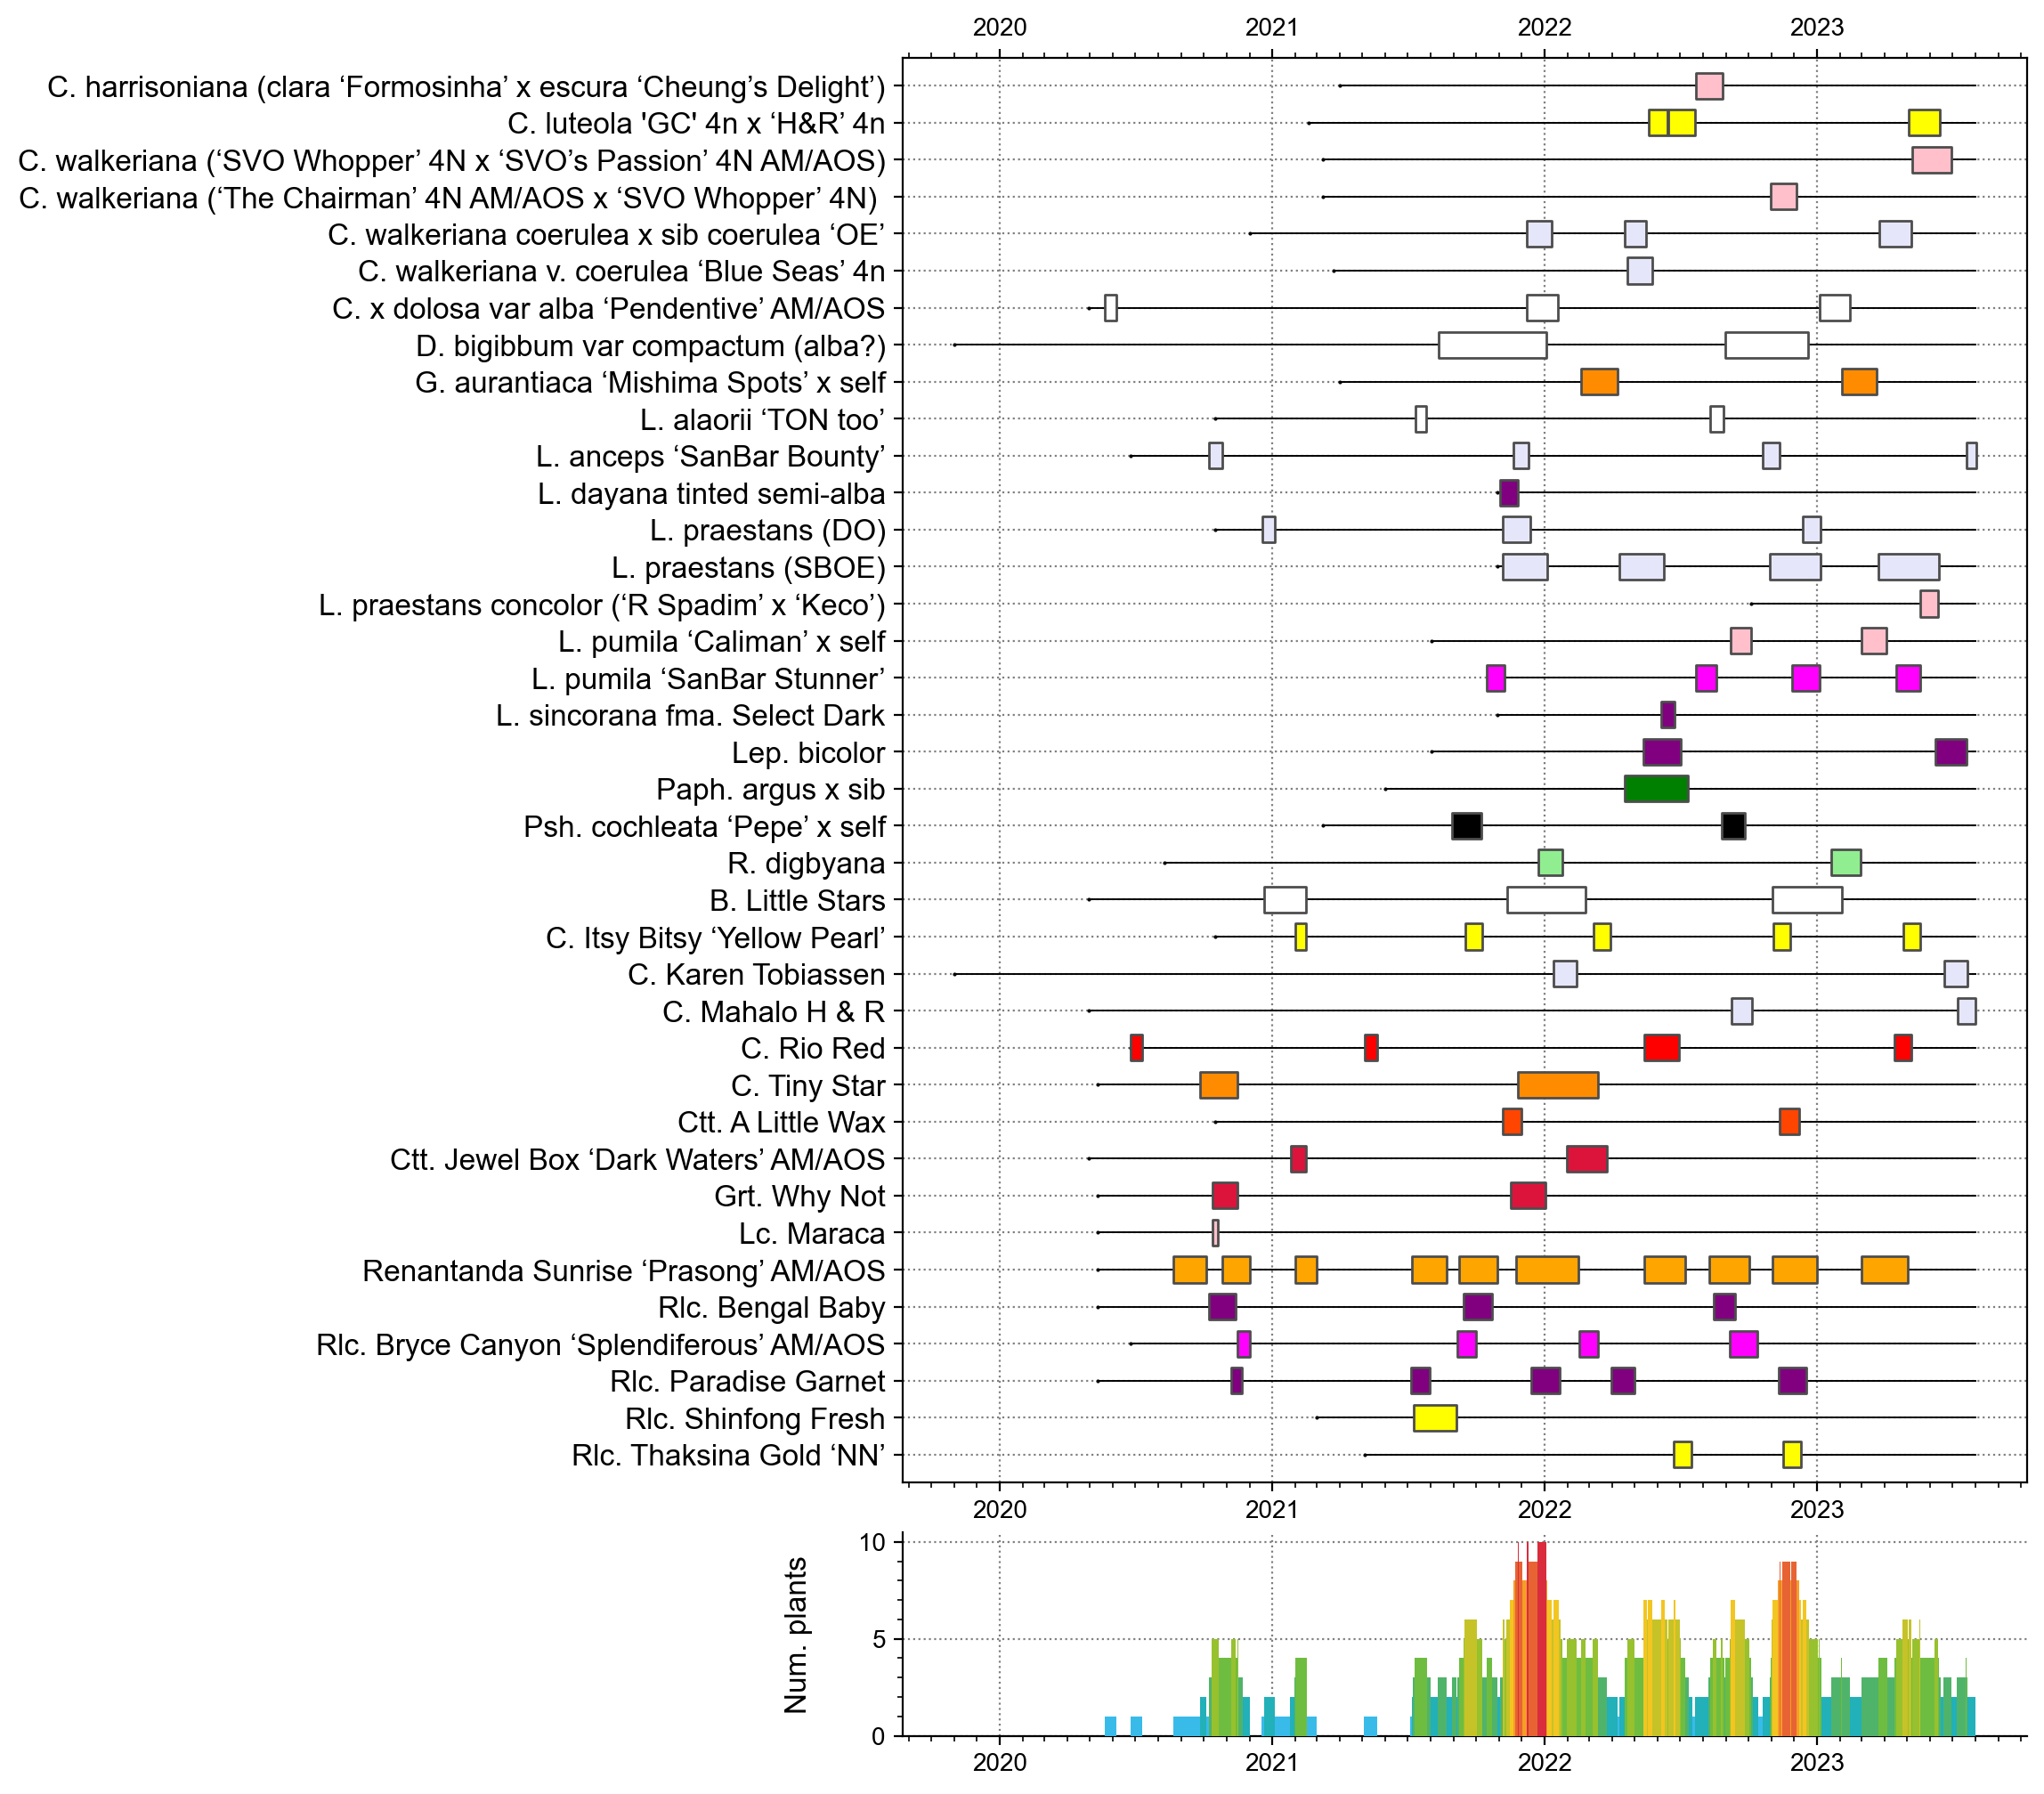

In [3]:
import csv
import sys
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from dateutil.parser import parse
from numbers_parser import Document

from matplotlib.collections import PolyCollection
from matplotlib.ticker import NullFormatter
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.font_manager as font_manager

def read_data_from_excel(file):
    """
    Read a multi-page Excel spreadsheet
    """
    xls = pd.ExcelFile(file)
    df_species = pd.read_excel(xls, 'species', parse_dates=True, date_format='MM/DD/YYYY')
    #df_species.info()
    #sys.exit()
    
    # Convert all columns to type object
    #df_species[df_species.notnull()] = df_species[df_species.notnull()].astype(str)
    #df_species.where(df_species.isna(), df_species.astype(str))
    
    # Now convert 'Start' columns to datetime
    #date_columns_species = [col for col in df_species.columns if 'Start' in col]
    #df_species[date_columns_species] = df_species[date_columns_species].apply(pd.to_datetime)

    
    df_hybrid = pd.read_excel(xls, 'hybrids', parse_dates=True, date_format='MM/DD/YYYY')

    #date_columns_hybrid = [col for col in df_hybrid.columns if 'Start' in col]
    #df_hybrid[date_columns_hybrid] = df_hybrid[date_columns_hybrid].apply(pd.to_datetime)
    
    return df_species, df_hybrid


def read_data_from_numbers(file):
    """
    Read a multi-page spreadsheet in Mac .numbers format
    """

    doc = Document(file)

    # read species from the first sheet
    sheets = doc.sheets
    species_tables = sheets[0].tables
    species_data = species_tables[0].rows(values_only=True)
    df_species = pd.DataFrame(species_data[1:], columns=species_data[0])

    # read hybrids from the second sheet
    hybrid_tables = sheets[1].tables
    hybrid_data = hybrid_tables[0].rows(values_only=True)
    df_hybrid = pd.DataFrame(hybrid_data[1:], columns=hybrid_data[0])
    
    return df_species, df_hybrid


def process_dataframe(df_species, df_hybrid):
    # concatenate the species and hybrid DataFrames
    df = pd.concat([df_species, df_hybrid], ignore_index=True)

    # Remove rows that have a blank 'Name' column.
    df = df.dropna(subset=['Name'])

    # Remove NOID plants
    df = df[~df['Name'].str.contains('NOID')]

    # Keep columns that contain the following words
    desired_words = ['Name', 'Color', 'Start', 'End', 'Purchased']
    columns_to_keep = [x for x in df.columns if any(word in x for word in desired_words)]
    df = df[columns_to_keep]

    # Get all the Start dates
    all_starts = [x for x in df.columns if 'Start' in x]

    # Convert date columns to datetime dtype
    date_columns = all_starts + [col.replace('Start', 'End') for col in all_starts] + ['Purchased']
    df[date_columns] = df[date_columns].apply(pd.to_datetime, utc=True)

    # Fill in missing colors with 'gray'.
    df['Color'].fillna('gray', inplace=True)

    # Drop rows for plants that haven't bloomed yet (i.e., 'Start1' = 'NaN').
    df.dropna(subset=[all_starts[0]], inplace=True)

    # Reset indices and start from 1 instead of 0 for plotting.
    df.reset_index(drop=True, inplace=True)
    df.index += 1

    return df, all_starts


# Main

#df_species, df_hybrid = read_data_from_numbers('my_plants.numbers')
#print(df_species.info())

df_species, df_hybrid = read_data_from_excel('my_plants.xlsx')
#print(df_species.info())

df, all_starts = process_dataframe(df_species, df_hybrid)

#print(df.head())
#sys.exit()

data = []

for row in df.itertuples(index=True):
    for start in all_starts:
        if pd.notnull(getattr(row, start)):
            end = start.replace("Start", "End")
            tmp = (getattr(row, start), getattr(row, end), row.Name)
            data.append(tmp)


# Make a dict of index:plant key-value pairs
plants = pd.Series(df.Name.to_dict())
colormapping = pd.Series(df.Color.to_dict())

# Invert the mapping to plant:index
plants = {v: k for k, v in plants.items()}

verts = []
colors = []

for d in data:
    v = [(mdates.date2num(d[0]), plants[d[2]] - 0.35),
         (mdates.date2num(d[0]), plants[d[2]] + 0.35),
         (mdates.date2num(d[1]), plants[d[2]] + 0.35),
         (mdates.date2num(d[1]), plants[d[2]] - 0.35),
         (mdates.date2num(d[0]), plants[d[2]] - 0.35)]
    verts.append(v)
    colors.append(colormapping[plants[d[2]]])

plt.rcParams["font.family"] = "Arial"  # Set the desired font name

cmap = LinearSegmentedColormap.from_list('my_gradient', (
  (0.000, (0.612, 0.824, 0.898)),
  (0.147, (0.027, 0.686, 0.922)),
  (0.272, (0.282, 0.694, 0.459)),
  (0.434, (0.471, 0.753, 0.196)),
  (0.727, (1.000, 0.776, 0.125)),
  (1.000, (0.851, 0.173, 0.239))))

facecolors = [cmap(x) for x in range(len(df.index))]

bars = PolyCollection(verts, facecolors=colors)
bars.set_zorder(11)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(7, 10), dpi=200, sharex=True, gridspec_kw={'height_ratios': [7, 1]})
fig.tight_layout()

ax.add_collection(bars)

ax.autoscale()
ax.set_axisbelow(True)

start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp.now()

years = mdates.YearLocator()
months = mdates.MonthLocator()
years_fmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_major_formatter(years_fmt)
ax.format_xdata = mdates.DateFormatter('%m/%Y')

# Add Xticks to the top of the plot
ax.xaxis.tick_top()

# Set the tick parameters
ax.tick_params(axis='x', which='both', bottom=True, top=True,
               labelbottom=True, labeltop=True)

# Set the y-axis limits
ax.set_ylim(0.25, len(df.index) + 0.75)
ax.set_yticks(range(1, len(df.index) + 1))
ax.set_yticklabels(list(plants.keys()), fontname='Arial', fontsize=12)
ax.xaxis.grid(color='gray', linestyle=':')
ax.yaxis.grid(color='gray', linestyle=':')
ax.invert_yaxis()

# Add black horizontal lines from 'Purchased' date to today's date
today = mdates.date2num(end_date)

for index, row in df.iterrows():
    purchase_date = mdates.date2num(row['Purchased'])
    ax.hlines(y=index, xmin=purchase_date, xmax=today, color='black',
              linewidth=0.7, linestyle='-')

    # Add a small black circle at the 'Purchased' date
    ax.plot(purchase_date, index, 'o', color='black', markersize=0.5)

for art in ax.get_children():
    if isinstance(art, PolyCollection):
        art.set_edgecolor((0.3, 0.3, 0.3))  # black

# Plot the total number of plants blooming each day
daily_counts = pd.Series(index=pd.date_range(start=start_date, end=end_date, freq='D'))
daily_counts = daily_counts.fillna(0)

for start, end, _ in data:
    start_dt = start.tz_convert(None)  # Convert tz-aware datetime to tz-naive datetime
    end_dt = end.tz_convert(None)  # Convert tz-aware datetime to tz-naive datetime
    daily_counts[start_dt:end_dt] += 1

ax2.bar(daily_counts.index, daily_counts.values, width=1,
        color=cmap(daily_counts.values / daily_counts.values.max()), zorder=10)


ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_minor_locator(months)
ax2.xaxis.set_major_formatter(years_fmt)
ax2.yaxis.set_major_locator(MultipleLocator(5))

ax2.set_ylabel('Num. plants', fontname='Arial', fontsize=12)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax2.xaxis.grid(color='gray', linestyle=':')
ax2.yaxis.grid(color='gray', linestyle=':')
ax2.yaxis.set_minor_locator(MultipleLocator(1))

for side in 'top,right'.split(','):
    ax2.spines[side].set_visible(False)

plt.setp(ax2.get_xticklabels(), rotation=0, ha="center")

fig.savefig('my_plants.png', dpi=200, bbox_inches='tight')
plt.show()